## Composite CBFQP with numpy
With composite CBF, there is only one constraint and therefore a closed-form solution to QP is available.

#### References
- https://dev10110.github.io/tech-notes/maths/qp_closed_form.html
- https://arxiv.org/abs/2309.06647
- https://arxiv.org/abs/2505.06794

In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt, binary_erosion
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import imageio


def poisson_cbf_from_occupancy(occ_grid):
    """
    Simple version to construct the poisson field w/o guidance field
    """
    ny, nx = occ_grid.shape
    dx = dy = 1.0

    dist_out = distance_transform_edt(occ_grid == 0)
    dist_in = distance_transform_edt(occ_grid == 1)
    signed_dist = dist_out - dist_in

    obs_interior = binary_erosion(occ_grid)
    obs_boundary = (occ_grid == 1) & (~obs_interior)

    f = -signed_dist / (np.max(np.abs(signed_dist)) + 1e-10)

    N = nx * ny
    main_diag = -4.0 * np.ones(N)
    side_diag = np.ones(N - 1)
    side_diag[np.arange(1, N) % nx == 0] = 0
    up_down_diag = np.ones(N - nx)
    A = diags([main_diag, side_diag, side_diag, up_down_diag, up_down_diag],
              [0, -1, 1, -nx, nx], format='csc') / dx**2

    f_flat = f.ravel()
    mask_boundary = obs_boundary.ravel()
    A = A.tolil()
    for i in np.where(mask_boundary)[0]:
        A[i, :] = 0
        A[i, i] = 1.0
        f_flat[i] = 0.0
    A = A.tocsc()

    h_flat = spsolve(A, f_flat)
    h = h_flat.reshape((ny, nx))
    return h


def cbfqp_poisson(state, nominal_control, h_field, alpha=1.0, grid_res=0.05):
    """
    CF solution using the poisson field as h
    Args:
        state: np.array([x, y]) in meters
        nominal_control: np.array([vx, vy])
        h_field: dict with keys 'h', 'dx', 'dy'
        alpha: relaxation gain
        grid_res: meter per grid cell
    """
    # Map state to grid coordinates
    x, y = state
    ny, nx = h_field['h'].shape
    gx = x / grid_res
    gy = y / grid_res

    # Interpolate h and gradients
    h_val = map_coordinates(h_field['h'], [[gy], [gx]], order=1)[0]
    dhx = map_coordinates(h_field['dhx'], [[gy], [gx]], order=1)[0]
    dhy = map_coordinates(h_field['dhy'], [[gy], [gx]], order=1)[0]
    # grad_h = np.array([dhx, dhy]).reshape(1, -1)
    grad_h = np.array([dhx, dhy]).flatten()

    # CBF constraint
    cbf_constr = (grad_h @ nominal_control + alpha * h_val).squeeze()
    if cbf_constr >= 0:
        return nominal_control.squeeze()
    else:
        correction = (cbf_constr / (grad_h @ grad_h.T).squeeze()) * grad_h.T
        return (nominal_control - correction).squeeze()


def clfqp(state, target_state, alpha=1.0):
    """
    Args:
        state: numpy array of shape (2,) for XY position
        target_state: numpy array of shape (2, ) for goal XY position
        alpha: tuning parameter of the CLF, the larger the more aggressive
    """
    nominal_control = np.zeros((2,))
    v = np.linalg.norm(state - target_state) ** 2
    Lfv = np.zeros((1,))
    Lgv = 2 * (state - target_state)
    clf_constr = (Lfv + Lgv @ nominal_control + alpha * v).squeeze()
    if clf_constr <= 0:
        return nominal_control.squeeze()
    else:
        return (nominal_control - clf_constr / (Lgv @ Lgv.T).squeeze() * Lgv.T).squeeze()



In [2]:
# Define the simulator
class OmniDirRobotSim:
    def __init__(self, world_width, world_height, robot_size):
        self.world_width = world_width
        self.world_height = world_height
        self.robot_size = robot_size
        self.position = np.array([0.5, 0.5])
        self.trajectory = []
        self.frames = []

    def move(self, vel_x, vel_y, dt=0.1):
        new_position = self.position + np.array([vel_x, vel_y]) * dt
        if 0 <= new_position[0] <= self.world_width and 0 <= new_position[1] <= self.world_height:
            self.position = new_position
        self.trajectory.append(tuple(self.position))

    def visualize(self, control_input, nominal_control, goal_position, occ_map, h_field, grid_res, save_frame=True):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(6, 6))

        # Background: show Poisson-CBF field h(x,y)
        extent = [0, occ_map.shape[1]*grid_res, 0, occ_map.shape[0]*grid_res]
        im = ax.imshow(h_field['h'], cmap='RdBu_r', origin='lower', extent=extent, alpha=0.7)
        ax.contour(
            np.linspace(0, extent[1], occ_map.shape[1]),
            np.linspace(0, extent[3], occ_map.shape[0]),
            h_field['h'],
            levels=[0],
            colors='black',
            linewidths=1.5
        )

        ax.set_xlim(0, self.world_width)
        ax.set_ylim(0, self.world_height)
        ax.set_aspect('equal')
        ax.grid(True, linestyle='--', alpha=0.4)

        # Plot trajectory
        if self.trajectory:
            traj_x, traj_y = zip(*self.trajectory)
            ax.plot(traj_x, traj_y, 'b-', alpha=0.7, linewidth=1.5, label='Trajectory')

        # Draw robot and goal
        rx, ry = self.position
        robot = plt.Circle((rx, ry), self.robot_size, color='blue', alpha=0.8, label='Robot')
        ax.add_patch(robot)

        gx, gy = goal_position
        goal = plt.Circle((gx, gy), 0.25, color='orange', alpha=1.0, label='Goal')
        ax.add_patch(goal)

        # Control arrows
        vx_nom, vy_nom = nominal_control
        ax.arrow(rx, ry, vx_nom, vy_nom, head_width=0.2, fc='r', ec='r', label='Nominal', alpha=0.8)

        vx_safe, vy_safe = control_input
        ax.arrow(rx, ry, vx_safe, vy_safe, head_width=0.2, fc='g', ec='g', label='Safe', alpha=0.8)

        ax.legend(loc='upper right', fontsize=8)
        ax.set_xlabel("X [m]")
        ax.set_ylabel("Y [m]")
        ax.set_title("Poisson-CBF Field and Robot Trajectory")

        if save_frame:
            fig.canvas.draw()
            frame = np.array(fig.canvas.renderer.buffer_rgba())
            self.frames.append(frame)

        display(fig)
        plt.close(fig)


    def save_gif(self, filename="robot_simulation.gif", fps=20):
        imageio.mimsave(filename, self.frames, fps=fps, loop=0)


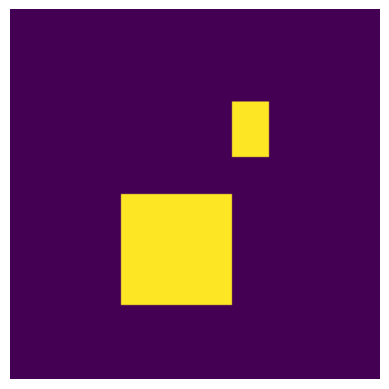

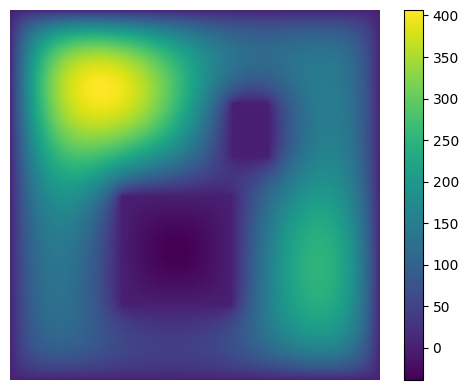

In [3]:
# Setup the map
grid_res = 0.05  # 5 cm per cell
nx, ny = int(10 / grid_res), int(10 / grid_res)
occ = np.zeros((ny, nx))
occ[int(2/grid_res):int(5/grid_res), int(3/grid_res):int(6/grid_res)] = 1  # obstacle 1
occ[int(6/grid_res):int(7.5/grid_res), int(6/grid_res):int(7.0/grid_res)] = 1  # obstacle 2
occ = np.flipud(occ)

plt.imshow(occ)
plt.axis('off')
plt.show()

# Compute h from Poisson (non-obstacle h > 0; on obstacle edge h = 0; inside obstacle h < 0)
h_im = poisson_cbf_from_occupancy(occ)
# Flip vertically -> world coordinates (y up)
h_world = np.flipud(h_im)
dhy_world, dhx_world = np.gradient(h_world, grid_res, grid_res)
h_field = {'h': h_world, 'dhx': dhx_world, 'dhy': dhy_world}
plt.imshow(h_im)
plt.colorbar()
plt.axis('off')
plt.show()

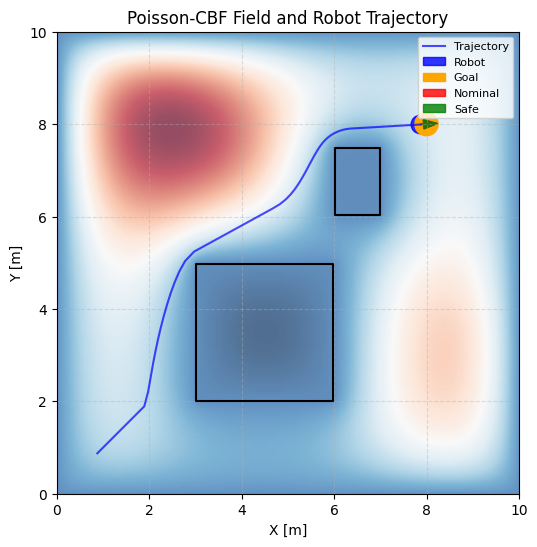

In [4]:
# Run simulation
robot = OmniDirRobotSim(10, 10, 0.2)
goal = np.array([8.0, 8.0])

for _ in range(100):
    nominal_control = clfqp(robot.position, goal, alpha=1.0)
    assert nominal_control.shape[0] == 2
    control_input = cbfqp_poisson(robot.position, nominal_control, h_field, alpha=0.3, grid_res=grid_res)
    robot.move(*control_input)
    robot.visualize(control_input, nominal_control, goal, occ, h_field, grid_res)

robot.save_gif("poisson_cbf_robot.gif")

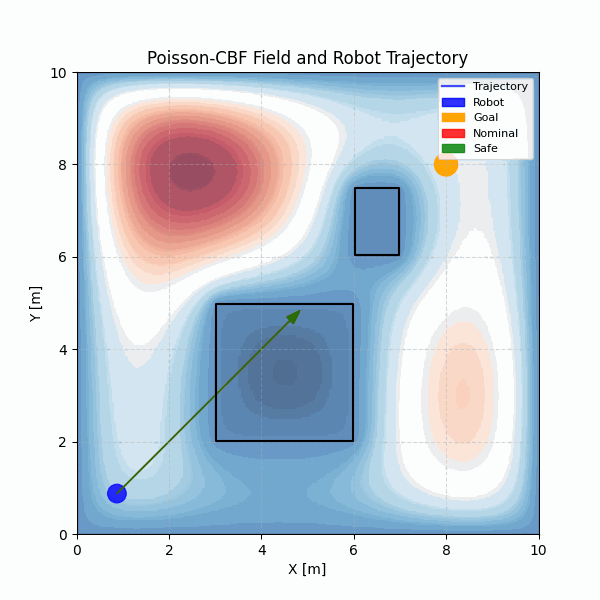

In [5]:
from IPython.display import Image
Image(open('poisson_cbf_robot.gif','rb').read())